## Ковешников Виктор, БЭК188

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('9_accept.csv')

# Вопрос №1. Какая доля 1 в выборке "accept"?

In [3]:
df['target'].value_counts()

0    31857
1      697
Name: target, dtype: int64

In [4]:
print('Доля единиц в выборке accept:', str(round(697/(697+31857)*100, 2)) + '%')

Доля единиц в выборке accept: 2.14%


Таким образом, видим, что в выборке из 32554 значений 697 человек имели просрочку в 90 дней или больше, то есть это около 2%.

# Вопрос №2. Рассчёт статистик для интервальных переменных

## Выборка accept

Подчистим данные, удалим колонку с ID, выделим целевую переменную и матрицу "объект-признак".

In [5]:
df.drop('UID', axis=1, inplace=True)

In [6]:
y = df['target']
X = df.drop('target', axis=1)

Выделим интервальные переменные, посмотрев на уникальные значения в каждом столбце

In [7]:
X.dtypes

INCOME_TYPE                   object
EDUCATION_                    object
CUSTOMER_CATEGORY_            object
income                       float64
DEPENDANT_NUMBER             float64
IS_EMPL                        int64
COUNT_ACTIVE_CREDIT_NO_CC    float64
CNT_MNTH_FROM_LAST_PMNT      float64
age                          float64
experience                   float64
inquiry_14_day               float64
inquiry_21_day               float64
count_mnth_act_passport      float64
dtype: object

In [8]:
inter_vars = list(X.dtypes[X.dtypes == 'float64'].index)
inter_vars

['income',
 'DEPENDANT_NUMBER',
 'COUNT_ACTIVE_CREDIT_NO_CC',
 'CNT_MNTH_FROM_LAST_PMNT',
 'age',
 'experience',
 'inquiry_14_day',
 'inquiry_21_day',
 'count_mnth_act_passport']

In [9]:
for i in inter_vars:
    print(i, X[i].unique())

income [140000.  12020.  21611. ...  30332.  49296.  23273.]
DEPENDANT_NUMBER [ 0.  2.  1.  3. nan  4.]
COUNT_ACTIVE_CREDIT_NO_CC [ 0.  1. nan  2.  6.  3.  4.  7.  5.  8.]
CNT_MNTH_FROM_LAST_PMNT [34.21854839  0.30378584         nan ...  0.73062276  0.17556004
 31.44101703]
age [38.49710308 36.43774235 33.33344562 ... 25.9224942  33.37905532
 25.79583053]
experience [ 4.06010929 17.73150685  1.71152781 ...  0.36669661  2.41605659
  2.53134217]
inquiry_14_day [nan  0.  1.  2.  3.  5.  4.  6.]
inquiry_21_day [nan  0.  1.  2.  3.  5.  4.  7.  6.  8.]
count_mnth_act_passport [10.05600719  9.1235347   7.9726776  ...  5.89783666  5.76021409
  6.59435586]


In [10]:
int_vars_df = X[inter_vars]

Исключим те переменные, которые имеют дискретную шкалу, поскольку их проще анализировать как категориальные

In [11]:
int_vars_df.drop(['DEPENDANT_NUMBER', 'COUNT_ACTIVE_CREDIT_NO_CC', 'inquiry_14_day', 'inquiry_21_day'], axis=1, inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Пропущенные значения

Изучим количество пропусков в интервальных переменных

In [12]:
int_vars_df.isna().sum()/int_vars_df.shape[0]*100

income                     2.150
CNT_MNTH_FROM_LAST_PMNT   31.028
age                        0.000
experience                 0.154
count_mnth_act_passport    0.000
dtype: float64

Везде, кроме переменной CNT_MNTH_FROM_LAST_PMNT, небольшая доля выбросов. Предлагается их не удалять, поскольку при использовании WoE они выделяются в отдельную категорию, благодаря тому, что WoE равняется нулю

### Выбросы

Построим "ящики с усами", чтобы определить наличие выбросов

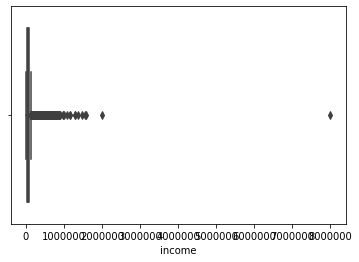

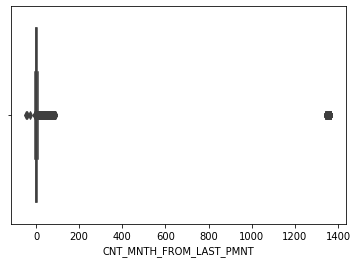

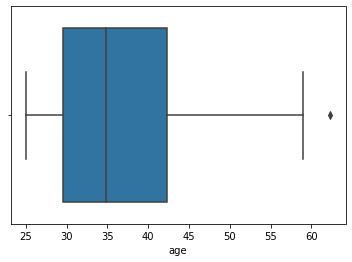

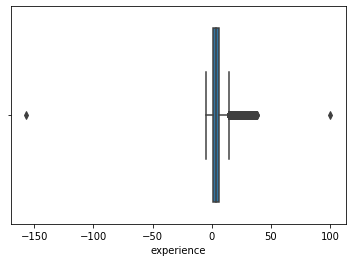

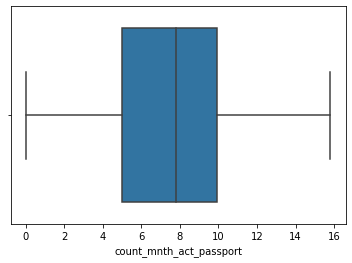

In [13]:
for i in int_vars_df.columns:
    sns.boxplot(int_vars_df[i])
    plt.show()

Выбросы удалять не требуется, поскольку WoE хорошо работает с ними, однако есть аномальные значения, которые не соответствуют смыслу переменных, а точнее: 1) отрицательный рабочий опыт в experience; 2) отрицательное количество месяцев, которое прошло с момента выдачи последнего кредита в CNT_MNTH_FROM_LAST_PMNT; 3) сверх-высокое количество месяцев с момента выдачи последнего кредита (1300+ месяцев, то есть больше, чем 112 лет назад). Данные значения будут удалены

In [14]:
df = df[~((df['CNT_MNTH_FROM_LAST_PMNT'] < 0) | (df['CNT_MNTH_FROM_LAST_PMNT'] > 90) | (df['experience'] < 0))]
df

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport
0,0,OTHER,elementary,NaN,140000.000,0.000,0,0.000,34.219,38.497,4.060,nan,nan,10.056
1,0,2NDFL,advanced,NaN,12020.000,0.000,0,1.000,0.304,36.438,17.732,0.000,0.000,9.124
2,0,OTHER,advanced,Corporate,21611.000,0.000,1,nan,nan,33.333,1.712,nan,nan,7.973
3,0,OTHER,elementary,VIP,146841.000,0.000,1,0.000,30.531,36.531,0.578,0.000,0.000,7.738
4,0,OTHER,elementary,NaN,50000.000,0.000,0,nan,nan,32.121,4.744,nan,nan,1.553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32549,1,OTHER,elementary,NaN,50000.000,0.000,0,1.000,1.245,33.379,3.030,1.000,1.000,11.178
32550,1,OTHER,advanced,NaN,32000.000,0.000,0,nan,nan,40.499,4.370,nan,nan,10.140
32551,1,OTHER,elementary,NaN,150000.000,0.000,0,nan,nan,27.732,2.416,nan,nan,7.675
32552,1,2NDFL,elementary,NaN,49296.000,0.000,0,0.000,nan,25.796,4.139,1.000,2.000,5.760


### Подсчёт описательных статистик

In [15]:
int_vars_df = df[int_vars_df.columns]
int_vars_df['target'] = df['target']
int_vars_df

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport,target
0,140000.000,34.219,38.497,4.060,10.056,0
1,12020.000,0.304,36.438,17.732,9.124,0
2,21611.000,nan,33.333,1.712,7.973,0
3,146841.000,30.531,36.531,0.578,7.738,0
4,50000.000,nan,32.121,4.744,1.553,0
...,...,...,...,...,...,...
32549,50000.000,1.245,33.379,3.030,11.178,1
32550,32000.000,nan,40.499,4.370,10.140,1
32551,150000.000,nan,27.732,2.416,7.675,1
32552,49296.000,nan,25.796,4.139,5.760,1


Подсчитаем все необходимые статистики

In [16]:
int_vars_df.describe()

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport,target
count,31117.000,21710.000,31809.000,31762.000,31809.000,31809.000
mean,61206.495,5.785,36.518,4.900,7.239,0.021
std,81511.229,12.298,8.234,5.246,3.343,0.143
min,0.000,0.000,25.000,0.000,0.000,0.000
25%,26968.000,0.539,29.595,1.243,4.962,0.000
50%,41588.000,0.948,34.812,3.292,7.779,0.000
75%,70000.000,3.537,42.384,6.487,9.899,0.000
max,8000000.000,89.053,62.321,100.355,15.805,1.000


### Преобразование интервальных переменных в категориалньые с помощью разделения данных на квантили

In [17]:
int_bins_vars = int_vars_df.copy()

In [18]:
pd.qcut(int_vars_df['income'], q=5)

0        (80000.0, 8000000.0]
1           (-0.001, 24948.4]
2           (-0.001, 24948.4]
3        (80000.0, 8000000.0]
4          (35000.0, 50000.0]
                 ...         
32549      (35000.0, 50000.0]
32550      (24948.4, 35000.0]
32551    (80000.0, 8000000.0]
32552      (35000.0, 50000.0]
32553       (-0.001, 24948.4]
Name: income, Length: 31809, dtype: category
Categories (5, interval[float64]): [(-0.001, 24948.4] < (24948.4, 35000.0] < (35000.0, 50000.0] < (50000.0, 80000.0] < (80000.0, 8000000.0]]

In [19]:
int_bins_vars['income'] = pd.qcut(int_vars_df['income'], q=5, labels=['income<=24948', '24948<income<=35000', '35000<income<=50000', '50000<income<=80000', 'income>80000'])

In [20]:
pd.qcut(int_vars_df['CNT_MNTH_FROM_LAST_PMNT'], q=5)

0        (6.046, 89.053]
1        (-0.001, 0.476]
2                    NaN
3        (6.046, 89.053]
4                    NaN
              ...       
32549     (1.145, 6.046]
32550                NaN
32551                NaN
32552                NaN
32553                NaN
Name: CNT_MNTH_FROM_LAST_PMNT, Length: 31809, dtype: category
Categories (5, interval[float64]): [(-0.001, 0.476] < (0.476, 0.763] < (0.763, 1.145] < (1.145, 6.046] < (6.046, 89.053]]

In [21]:
int_bins_vars['CNT_MNTH_FROM_LAST_PMNT'] = pd.qcut(int_vars_df['CNT_MNTH_FROM_LAST_PMNT'], q=5, labels=['CNT_MNTH_FROM_LAST_PMNT<=0.476', '0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763', '0.763<CNT_MNTH_FROM_LAST_PMNT<=1.145', '1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046', 'CNT_MNTH_FROM_LAST_PMNT>6.046'])

In [22]:
pd.qcut(int_vars_df['age'], q=5)

0        (37.533, 44.435]
1        (32.505, 37.533]
2        (32.505, 37.533]
3        (32.505, 37.533]
4        (28.741, 32.505]
               ...       
32549    (32.505, 37.533]
32550    (37.533, 44.435]
32551    (24.999, 28.741]
32552    (24.999, 28.741]
32553    (24.999, 28.741]
Name: age, Length: 31809, dtype: category
Categories (5, interval[float64]): [(24.999, 28.741] < (28.741, 32.505] < (32.505, 37.533] < (37.533, 44.435] < (44.435, 62.321]]

In [23]:
int_bins_vars['age'] = pd.qcut(int_vars_df['age'], q=5, labels=['age<=28.741', '28.741<age<=32.505', '32.505<age<=37.533', '37.533<age<=44.435', 'age>44.435'])

In [24]:
pd.qcut(int_vars_df['experience'], q=5)

0          (2.327, 4.433]
1        (7.499, 100.355]
2          (0.957, 2.327]
3         (-0.001, 0.957]
4          (4.433, 7.499]
               ...       
32549      (2.327, 4.433]
32550      (2.327, 4.433]
32551      (2.327, 4.433]
32552      (2.327, 4.433]
32553      (2.327, 4.433]
Name: experience, Length: 31809, dtype: category
Categories (5, interval[float64]): [(-0.001, 0.957] < (0.957, 2.327] < (2.327, 4.433] < (4.433, 7.499] < (7.499, 100.355]]

In [25]:
int_bins_vars['experience'] = pd.qcut(int_vars_df['experience'], q=5, labels=['experience<=0.957', '0.957<experience<=2.327', '2.327<experience<=4.433', '4.433<experience<=7.499', 'experience>7.499'])

In [26]:
pd.qcut(int_vars_df['count_mnth_act_passport'], q=5)

0         (8.827, 10.239]
1         (8.827, 10.239]
2          (6.647, 8.827]
3          (6.647, 8.827]
4         (-0.001, 4.139]
               ...       
32549    (10.239, 15.805]
32550     (8.827, 10.239]
32551      (6.647, 8.827]
32552      (4.139, 6.647]
32553      (4.139, 6.647]
Name: count_mnth_act_passport, Length: 31809, dtype: category
Categories (5, interval[float64]): [(-0.001, 4.139] < (4.139, 6.647] < (6.647, 8.827] < (8.827, 10.239] < (10.239, 15.805]]

In [27]:
int_bins_vars['count_mnth_act_passport'] = pd.qcut(int_vars_df['count_mnth_act_passport'], q=5, labels=['count_mnth_act_passport<=4.139', '4.139<count_mnth_act_passport<=6.647', '6.647<count_mnth_act_passport<=8.827', '8.827<count_mnth_act_passport<=10.239', 'count_mnth_act_passport>10.239'])

In [28]:
int_bins_vars

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport,target
0,income>80000,CNT_MNTH_FROM_LAST_PMNT>6.046,37.533<age<=44.435,2.327<experience<=4.433,8.827<count_mnth_act_passport<=10.239,0
1,income<=24948,CNT_MNTH_FROM_LAST_PMNT<=0.476,32.505<age<=37.533,experience>7.499,8.827<count_mnth_act_passport<=10.239,0
2,income<=24948,NaN,32.505<age<=37.533,0.957<experience<=2.327,6.647<count_mnth_act_passport<=8.827,0
3,income>80000,CNT_MNTH_FROM_LAST_PMNT>6.046,32.505<age<=37.533,experience<=0.957,6.647<count_mnth_act_passport<=8.827,0
4,35000<income<=50000,NaN,28.741<age<=32.505,4.433<experience<=7.499,count_mnth_act_passport<=4.139,0
...,...,...,...,...,...,...
32549,35000<income<=50000,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,32.505<age<=37.533,2.327<experience<=4.433,count_mnth_act_passport>10.239,1
32550,24948<income<=35000,NaN,37.533<age<=44.435,2.327<experience<=4.433,8.827<count_mnth_act_passport<=10.239,1
32551,income>80000,NaN,age<=28.741,2.327<experience<=4.433,6.647<count_mnth_act_passport<=8.827,1
32552,35000<income<=50000,NaN,age<=28.741,2.327<experience<=4.433,4.139<count_mnth_act_passport<=6.647,1


In [29]:
int_bins_vars = int_bins_vars.astype('object')
int_bins_vars = int_bins_vars.fillna('NaN')
int_bins_vars['target'] = int_bins_vars['target'].astype('int')

### Написанный мною ниже код преобразовывает категориальные переменные в их WoE значения, параллельно подсчитывая Information Value. Однако совершение преобразования на всей выборке может вызвать проблему переобучения, поэтому конечное WoE-преобразование будет выполняться ниже при обучении логистической регресии. Код ниже прогоняется с целью посчитать Information Value для каждой интервальной переменной

In [30]:
WoE_int_vars = int_bins_vars.copy()
WoE_int_vars.fillna('NaN')
IV_total = []
for i in range(len(int_bins_vars.columns)):
    lst = []
    IV = []
    for j in range(len(int_bins_vars.iloc[:, i].unique())):
        val = int_bins_vars.iloc[:, i].unique()[j]
        target_sum = int_bins_vars[int_bins_vars.iloc[:, i] == val]['target'].sum() #Количество единиц
        zero_sum = (int_bins_vars[int_bins_vars.iloc[:, i] == val]['target'].count() - target_sum) #Количество нулей
        rel_freq_1 = target_sum/int_bins_vars['target'].sum()
        rel_freq_0 = zero_sum/(int_bins_vars['target'].count() - int_bins_vars['target'].sum())
        if rel_freq_1 == 0:
            rel_freq_1 = 0.000001
        if rel_freq_0 == 0:
            rel_freq_0 = 0.000001
        var_WoE = np.log(rel_freq_0 / rel_freq_1)
        IV_value = (rel_freq_0 - rel_freq_1)*var_WoE
        IV.append(IV_value)
        lst.append(var_WoE)
        WoE_int_vars[int_bins_vars.columns[i]][WoE_int_vars[int_bins_vars.columns[i]] == val] = lst[j]
    IV_total.append(sum(IV))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [31]:
IV_df = pd.DataFrame()
IV_df['variable'] = int_bins_vars.columns
IV_df['Information Value'] = IV_total
IV_df.drop(5, axis=0)

,variable,Information Value
0,income,0.129
1,CNT_MNTH_FROM_LAST_PMNT,0.118
2,age,0.003
3,experience,0.604
4,count_mnth_act_passport,0.056


## Выборка reject

Все аналогичные операции проделываем для выборки reject

In [32]:
df_r = pd.read_csv('9_reject.csv')

In [33]:
df_r

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport,UID
0,2NDFL,elementary,NaN,26106.000,0.000,0,0.000,1.667,24.353,3.284,1.000,1.000,4.268,12
1,2NDFL,elementary,NaN,30276.000,0.000,0,1.000,0.660,23.534,3.581,0.000,0.000,1.411,27
2,2NDFL,advanced,NaN,23147.000,0.000,0,0.000,4.342,24.580,0.646,0.000,1.000,4.544,33
3,2NDFL,advanced,NaN,33116.000,0.000,0,0.000,0.759,23.284,0.901,0.000,0.000,3.183,41
4,2NDFL,elementary,NaN,45972.000,0.000,0,nan,nan,24.529,1.405,nan,nan,3.582,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,2NDFL,advanced,NaN,24311.000,0.000,0,nan,nan,23.456,1.188,nan,nan,3.402,140863
10689,OTHER,elementary,NaN,21400.000,0.000,0,0.000,1.272,24.041,0.994,0.000,0.000,2.740,140864
10690,OTHER,elementary,Corporate,22532.000,0.000,1,1.000,0.601,24.443,0.569,1.000,1.000,4.377,140869
10691,OTHER,elementary,NaN,21750.000,0.000,0,nan,nan,23.219,0.742,nan,nan,3.002,140885


In [34]:
df_r.drop('UID', axis=1, inplace=True)
X = df_r

### Выделение интервальных переменных

In [35]:
inter_vars = list(X.dtypes[X.dtypes == 'float64'].index)
inter_vars

['income',
 'DEPENDANT_NUMBER',
 'COUNT_ACTIVE_CREDIT_NO_CC',
 'CNT_MNTH_FROM_LAST_PMNT',
 'age',
 'experience',
 'inquiry_14_day',
 'inquiry_21_day',
 'count_mnth_act_passport']

In [36]:
for i in inter_vars:
    print(i, X[i].unique())

income [26106. 30276. 23147. ... 21400. 22532. 12432.]
DEPENDANT_NUMBER [ 0.  1. nan  2.]
COUNT_ACTIVE_CREDIT_NO_CC [ 0.  1. nan  2.  3.  5.  4.  6.]
CNT_MNTH_FROM_LAST_PMNT [1.66680108 0.66046147 4.34202509 ... 2.08351254 1.27155018 0.60129928]
age [24.3531926  23.5344936  24.58002096 ... 24.87818699 23.05442024
 24.83429897]
experience [3.28415301 3.58106894 0.64577438 ... 1.18806048 0.99430347 0.56853058]
inquiry_14_day [ 1.  0. nan  2.  4.  6.  3.  5.]
inquiry_21_day [ 1.  0. nan  2.  4.  3.  6.  5.  8.]
count_mnth_act_passport [4.2682611  1.41120593 4.54440452 ... 4.61238117 2.73950895 3.00231305]


In [37]:
int_vars_df_r = X[inter_vars]
int_vars_df_r.drop(['DEPENDANT_NUMBER', 'COUNT_ACTIVE_CREDIT_NO_CC', 'inquiry_14_day', 'inquiry_21_day'], axis=1, inplace=True)

D:\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Пропущенные значения

In [38]:
int_vars_df_r.isna().sum()/int_vars_df_r.shape[0]*100

income                     5.106
CNT_MNTH_FROM_LAST_PMNT   51.127
age                        0.000
experience                 0.075
count_mnth_act_passport    0.000
dtype: float64

### Выбросы

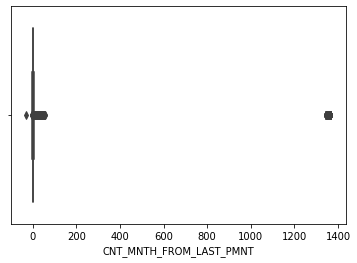

In [39]:
sns.boxplot(int_vars_df_r['CNT_MNTH_FROM_LAST_PMNT'])

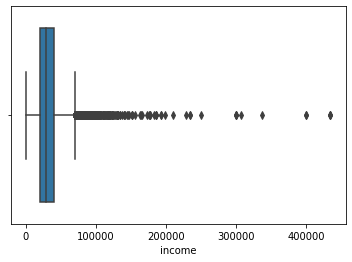

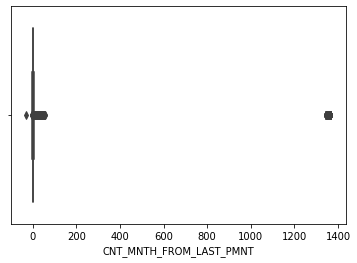

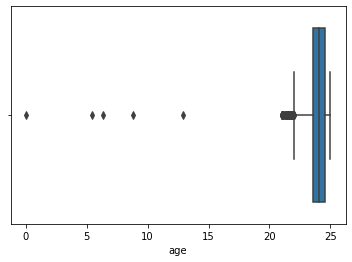

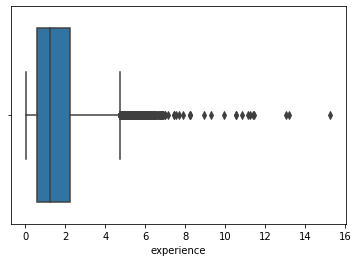

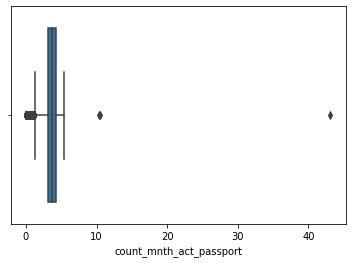

In [40]:
for i in int_vars_df_r.columns:
    sns.boxplot(int_vars_df_r[i])
    plt.show()

In [41]:
int_vars_df_r['CNT_MNTH_FROM_LAST_PMNT'].sort_values()

2325    -31.073
9297     -4.405
3761     -4.270
8063     -3.725
4325     -2.168
          ...  
10685       nan
10686       nan
10687       nan
10688       nan
10691       nan
Name: CNT_MNTH_FROM_LAST_PMNT, Length: 10693, dtype: float64

Как и в выборке accept имеем отрицательное количество месяцев, которое прошло с момента выдачи последнего кредита в CNT_MNTH_FROM_LAST_PMNT, а также сверх-высокое количество месяцев с момента выдачи последнего кредита (1300+ месяцев, то есть больше, чем 112 лет назад). Данные значения будут удалены

In [42]:
df_r = df_r[~((df_r['CNT_MNTH_FROM_LAST_PMNT'] < 0) | (df_r['CNT_MNTH_FROM_LAST_PMNT'] > 90) | (df_r['experience'] < 0))]
df_r

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport
0,2NDFL,elementary,NaN,26106.000,0.000,0,0.000,1.667,24.353,3.284,1.000,1.000,4.268
1,2NDFL,elementary,NaN,30276.000,0.000,0,1.000,0.660,23.534,3.581,0.000,0.000,1.411
2,2NDFL,advanced,NaN,23147.000,0.000,0,0.000,4.342,24.580,0.646,0.000,1.000,4.544
3,2NDFL,advanced,NaN,33116.000,0.000,0,0.000,0.759,23.284,0.901,0.000,0.000,3.183
4,2NDFL,elementary,NaN,45972.000,0.000,0,nan,nan,24.529,1.405,nan,nan,3.582
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,2NDFL,advanced,NaN,24311.000,0.000,0,nan,nan,23.456,1.188,nan,nan,3.402
10689,OTHER,elementary,NaN,21400.000,0.000,0,0.000,1.272,24.041,0.994,0.000,0.000,2.740
10690,OTHER,elementary,Corporate,22532.000,0.000,1,1.000,0.601,24.443,0.569,1.000,1.000,4.377
10691,OTHER,elementary,NaN,21750.000,0.000,0,nan,nan,23.219,0.742,nan,nan,3.002


In [43]:
int_vars_df_r = df_r[int_vars_df_r.columns]
int_vars_df_r

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport
0,26106.000,1.667,24.353,3.284,4.268
1,30276.000,0.660,23.534,3.581,1.411
2,23147.000,4.342,24.580,0.646,4.544
3,33116.000,0.759,23.284,0.901,3.183
4,45972.000,nan,24.529,1.405,3.582
...,...,...,...,...,...
10688,24311.000,nan,23.456,1.188,3.402
10689,21400.000,1.272,24.041,0.994,2.740
10690,22532.000,0.601,24.443,0.569,4.377
10691,21750.000,nan,23.219,0.742,3.002


### Рассчёт описательных характеристик для отложенной выборки

In [44]:
int_vars_df_r.describe()

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport
count,9854.000,4928.000,10395.000,10387.000,10395.000
mean,33677.760,2.720,24.038,1.666,3.510
std,21671.028,5.477,0.742,1.397,1.157
min,0.000,0.000,0.003,0.025,0.003
25%,20793.750,0.533,23.548,0.605,3.063
50%,29154.500,0.864,24.110,1.233,3.713
75%,40379.500,1.637,24.583,2.258,4.295
max,434136.000,57.897,25.000,15.271,43.099


# Вопрос №3. Рассчёт статистик для категориальных переменных

## Выборка accept

### Убираем те наблюдения, которые на предыдущем этапе работы с интервальными переменными оказались аномальными

In [45]:
df = df[~((df['CNT_MNTH_FROM_LAST_PMNT'] < 0) | (df['CNT_MNTH_FROM_LAST_PMNT'] > 90) | (df['experience'] < 0))]
df

,target,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,income,DEPENDANT_NUMBER,IS_EMPL,COUNT_ACTIVE_CREDIT_NO_CC,CNT_MNTH_FROM_LAST_PMNT,age,experience,inquiry_14_day,inquiry_21_day,count_mnth_act_passport
0,0,OTHER,elementary,NaN,140000.000,0.000,0,0.000,34.219,38.497,4.060,nan,nan,10.056
1,0,2NDFL,advanced,NaN,12020.000,0.000,0,1.000,0.304,36.438,17.732,0.000,0.000,9.124
2,0,OTHER,advanced,Corporate,21611.000,0.000,1,nan,nan,33.333,1.712,nan,nan,7.973
3,0,OTHER,elementary,VIP,146841.000,0.000,1,0.000,30.531,36.531,0.578,0.000,0.000,7.738
4,0,OTHER,elementary,NaN,50000.000,0.000,0,nan,nan,32.121,4.744,nan,nan,1.553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32549,1,OTHER,elementary,NaN,50000.000,0.000,0,1.000,1.245,33.379,3.030,1.000,1.000,11.178
32550,1,OTHER,advanced,NaN,32000.000,0.000,0,nan,nan,40.499,4.370,nan,nan,10.140
32551,1,OTHER,elementary,NaN,150000.000,0.000,0,nan,nan,27.732,2.416,nan,nan,7.675
32552,1,2NDFL,elementary,NaN,49296.000,0.000,0,0.000,nan,25.796,4.139,1.000,2.000,5.760


### Определим категориальные переменные

In [46]:
cat_vars = list(X.dtypes[X.dtypes == 'object'].index) + list(['IS_EMPL', 'DEPENDANT_NUMBER', 'COUNT_ACTIVE_CREDIT_NO_CC', 'inquiry_14_day', 'inquiry_21_day'])

In [47]:
cat_vars_df = df[cat_vars]
cat_vars_df['target'] = df['target']
cat_vars_df = cat_vars_df.astype('object')
cat_vars_df

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day,target
0,OTHER,elementary,NaN,0,0.000,0.000,NaN,NaN,0
1,2NDFL,advanced,NaN,0,0.000,1.000,0.000,0.000,0
2,OTHER,advanced,Corporate,1,0.000,NaN,NaN,NaN,0
3,OTHER,elementary,VIP,1,0.000,0.000,0.000,0.000,0
4,OTHER,elementary,NaN,0,0.000,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
32549,OTHER,elementary,NaN,0,0.000,1.000,1.000,1.000,1
32550,OTHER,advanced,NaN,0,0.000,NaN,NaN,NaN,1
32551,OTHER,elementary,NaN,0,0.000,NaN,NaN,NaN,1
32552,2NDFL,elementary,NaN,0,0.000,0.000,1.000,2.000,1


### Пропущенные значения

In [48]:
cat_vars_df.isna().sum()/cat_vars_df.shape[0]*100

INCOME_TYPE                  0.000
EDUCATION_                   0.000
CUSTOMER_CATEGORY_          59.436
IS_EMPL                      0.000
DEPENDANT_NUMBER             0.132
COUNT_ACTIVE_CREDIT_NO_CC   25.999
inquiry_14_day              28.630
inquiry_21_day              28.630
target                       0.000
dtype: float64

Хотя есть категории с большим количеством пропусков, эти пропуски не будут удалены, поскольку они хорошо обрабатываются с помощью WoE.

### Выбросы

In [49]:
for i in cat_vars:
    print(X[i].unique())

['2NDFL' 'OTHER']
['elementary' 'advanced' 'high' 'beginner']
[nan 'Corporate' 'VIP']
[0 1]
[ 0.  1. nan  2.]
[ 0.  1. nan  2.  3.  5.  4.  6.]
[ 1.  0. nan  2.  4.  6.  3.  5.]
[ 1.  0. nan  2.  4.  3.  6.  5.  8.]


Аномальных значений в категориальных переменных не наблюдается

### Расчёт статистик по категориальным переменным

In [50]:
cat_vars_df.describe()

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day,target
count,31809,31809,12903,31809,31767.000,23539.000,22702.000,22702.000,31809
unique,2,4,2,2,5.000,9.000,7.000,9.000,2
top,OTHER,elementary,Corporate,0,0.000,0.000,0.000,0.000,0
freq,21377,20831,12491,19124,31579.000,11868.000,16204.000,15343.000,31148


Выделяем пропущенные значения в отдельную категориальную переменную для корректной обработки с помощью WoE

In [51]:
cat_vars_df = cat_vars_df.fillna('NaN')

### Как и в пункте с интервальными переменными, проделываем пока WoE-преобразование на всей выборке, чтобы подсчитать Information Value по всей выборке, однако ниже при объединении интервальных и категориальных переменных WoE-преобразование будет осуществлено лишь на части выборки.

In [52]:
WoE_cat_vars = cat_vars_df.copy()
IV_total = []
for i in range(len(cat_vars_df.columns)):
    lst = []
    IV = []
    for j in range(len(cat_vars_df.iloc[:, i].unique())):
        val = cat_vars_df.iloc[:, i].unique()[j]
        target_sum = cat_vars_df[cat_vars_df.iloc[:, i] == val]['target'].sum() #Количество единиц
        zero_sum = (cat_vars_df[cat_vars_df.iloc[:, i] == val]['target'].count() - target_sum) #Количество нулей
        rel_freq_1 = target_sum/cat_vars_df['target'].sum()
        rel_freq_0 = zero_sum/(cat_vars_df['target'].count() - cat_vars_df['target'].sum())
        if rel_freq_1 == 0:
            rel_freq_1 = 0.000001
        if rel_freq_0 == 0:
            rel_freq_0 = 0.000001
        var_WoE = np.log(rel_freq_0 / rel_freq_1)
        IV_value = (rel_freq_0 - rel_freq_1)*var_WoE
        IV.append(IV_value)
        lst.append(var_WoE)
        WoE_cat_vars[cat_vars_df.columns[i]][WoE_cat_vars[cat_vars_df.columns[i]] == val] = lst[j]
    IV_total.append(sum(IV))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
IV_df = pd.DataFrame()
IV_df['variable'] = cat_vars_df.columns
IV_df['Information Value'] = IV_total
IV_df.drop(8, axis=0)

,variable,Information Value
0,INCOME_TYPE,0.005
1,EDUCATION_,0.035
2,CUSTOMER_CATEGORY_,0.455
3,IS_EMPL,0.711
4,DEPENDANT_NUMBER,0.476
5,COUNT_ACTIVE_CREDIT_NO_CC,0.140
6,inquiry_14_day,0.175
7,inquiry_21_day,0.195


In [54]:
WoE_cat_vars['target'] = cat_vars_df['target']
WoE_cat_vars

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day,target
0,-0.049,0.130,-0.396,-0.443,0.065,0.415,-0.330,-0.330,0
1,0.108,-0.207,-0.396,-0.443,0.065,0.147,0.415,0.434,0
2,-0.049,-0.207,1.204,1.700,0.065,-0.409,-0.330,-0.330,0
3,-0.049,0.130,0.772,1.700,0.065,0.415,0.415,0.434,0
4,-0.049,0.130,-0.396,-0.443,0.065,-0.409,-0.330,-0.330,0
...,...,...,...,...,...,...,...,...,...
32549,-0.049,0.130,-0.396,-0.443,0.065,0.147,-0.123,0.016,1
32550,-0.049,-0.207,-0.396,-0.443,0.065,-0.409,-0.330,-0.330,1
32551,-0.049,0.130,-0.396,-0.443,0.065,-0.409,-0.330,-0.330,1
32552,0.108,0.130,-0.396,-0.443,0.065,0.415,-0.123,-0.724,1


## Выборка reject

### Аналогичные действия проделываем и с выборкой reject

In [55]:
df_r = pd.read_csv('9_reject.csv')
df_r = df_r[~((df_r['CNT_MNTH_FROM_LAST_PMNT'] < 0) | (df_r['CNT_MNTH_FROM_LAST_PMNT'] > 90) | (df_r['experience'] < 0))]

In [56]:
cat_vars_df_r = df_r[cat_vars]
cat_vars_df_r = cat_vars_df_r.astype('object')
cat_vars_df_r

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day
0,2NDFL,elementary,NaN,0,0.000,0.000,1.000,1.000
1,2NDFL,elementary,NaN,0,0.000,1.000,0.000,0.000
2,2NDFL,advanced,NaN,0,0.000,0.000,0.000,1.000
3,2NDFL,advanced,NaN,0,0.000,0.000,0.000,0.000
4,2NDFL,elementary,NaN,0,0.000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
10688,2NDFL,advanced,NaN,0,0.000,NaN,NaN,NaN
10689,OTHER,elementary,NaN,0,0.000,0.000,0.000,0.000
10690,OTHER,elementary,Corporate,1,0.000,1.000,1.000,1.000
10691,OTHER,elementary,NaN,0,0.000,NaN,NaN,NaN


### Пропущенные значения

In [57]:
cat_vars_df_r.isna().sum()/cat_vars_df_r.shape[0]*100

INCOME_TYPE                  0.000
EDUCATION_                   0.000
CUSTOMER_CATEGORY_          47.109
IS_EMPL                      0.000
DEPENDANT_NUMBER             0.048
COUNT_ACTIVE_CREDIT_NO_CC   42.405
inquiry_14_day              44.204
inquiry_21_day              44.204
dtype: float64

### Аномальные значения

In [58]:
for i in cat_vars:
    print(X[i].unique())

['2NDFL' 'OTHER']
['elementary' 'advanced' 'high' 'beginner']
[nan 'Corporate' 'VIP']
[0 1]
[ 0.  1. nan  2.]
[ 0.  1. nan  2.  3.  5.  4.  6.]
[ 1.  0. nan  2.  4.  6.  3.  5.]
[ 1.  0. nan  2.  4.  3.  6.  5.  8.]


Аномальных значений в категориальных переменных не наблюдается

### Рассчёт описательных статистик для отложенной выборки

In [59]:
cat_vars_df_r.describe()

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day
count,10395,10395,5498,10395,10390.000,5987.000,5800.000,5800.000
unique,2,4,2,2,3.000,6.000,7.000,8.000
top,OTHER,elementary,Corporate,1,0.000,0.000,0.000,0.000
freq,6497,6573,5487,5694,10373.000,3357.000,4309.000,4048.000


# Вопрос №4. Построить логистическую регрессию только на одобренных заявках с преобразованными переменными 

### Объединяем интервальные (разделенные на 5 бинов) и категориальные переменные

In [60]:
df_vars_combined = int_bins_vars.drop('target', axis=1).join(cat_vars_df)

In [61]:
df_vars_combined

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day,target
0,income>80000,CNT_MNTH_FROM_LAST_PMNT>6.046,37.533<age<=44.435,2.327<experience<=4.433,8.827<count_mnth_act_passport<=10.239,OTHER,elementary,NaN,0,0.000,0.000,NaN,NaN,0
1,income<=24948,CNT_MNTH_FROM_LAST_PMNT<=0.476,32.505<age<=37.533,experience>7.499,8.827<count_mnth_act_passport<=10.239,2NDFL,advanced,NaN,0,0.000,1.000,0.000,0.000,0
2,income<=24948,NaN,32.505<age<=37.533,0.957<experience<=2.327,6.647<count_mnth_act_passport<=8.827,OTHER,advanced,Corporate,1,0.000,NaN,NaN,NaN,0
3,income>80000,CNT_MNTH_FROM_LAST_PMNT>6.046,32.505<age<=37.533,experience<=0.957,6.647<count_mnth_act_passport<=8.827,OTHER,elementary,VIP,1,0.000,0.000,0.000,0.000,0
4,35000<income<=50000,NaN,28.741<age<=32.505,4.433<experience<=7.499,count_mnth_act_passport<=4.139,OTHER,elementary,NaN,0,0.000,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32549,35000<income<=50000,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,32.505<age<=37.533,2.327<experience<=4.433,count_mnth_act_passport>10.239,OTHER,elementary,NaN,0,0.000,1.000,1.000,1.000,1
32550,24948<income<=35000,NaN,37.533<age<=44.435,2.327<experience<=4.433,8.827<count_mnth_act_passport<=10.239,OTHER,advanced,NaN,0,0.000,NaN,NaN,NaN,1
32551,income>80000,NaN,age<=28.741,2.327<experience<=4.433,6.647<count_mnth_act_passport<=8.827,OTHER,elementary,NaN,0,0.000,NaN,NaN,NaN,1
32552,35000<income<=50000,NaN,age<=28.741,2.327<experience<=4.433,4.139<count_mnth_act_passport<=6.647,2NDFL,elementary,NaN,0,0.000,0.000,1.000,2.000,1


### Чтобы избежать проблемы переобучения, проводим WoE-преобразование на 80% выборки.

In [62]:
y = df_vars_combined['target']
X = df_vars_combined.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
df_vars_combined_train = X_train.join(y_train)

### WoE-преобразование проводим на 80% выборки, однако, заполняем получившимися WoE-значениями всю выборку

In [64]:
WoE_vars = df_vars_combined.copy()
IV_total = []
for i in range(len(df_vars_combined_train.columns)):
    lst = []
    IV = []
    for j in range(len(df_vars_combined_train.iloc[:, i].unique())):
        val = df_vars_combined_train.iloc[:, i].unique()[j]
        target_sum = df_vars_combined_train[df_vars_combined_train.iloc[:, i] == val]['target'].sum() #Количество единиц
        zero_sum = (df_vars_combined_train[df_vars_combined_train.iloc[:, i] == val]['target'].count() - target_sum) #Количество нулей
        rel_freq_1 = target_sum/df_vars_combined_train['target'].sum()
        rel_freq_0 = zero_sum/(df_vars_combined_train['target'].count() - df_vars_combined_train['target'].sum())
        if rel_freq_1 == 0:
            rel_freq_1 = 0.000001
        if rel_freq_0 == 0:
            rel_freq_0 = 0.000001
        var_WoE = np.log(rel_freq_0 / rel_freq_1)
        IV_value = (rel_freq_0 - rel_freq_1)*var_WoE
        IV.append(IV_value)
        lst.append(var_WoE)
        WoE_vars[df_vars_combined.columns[i]][WoE_vars[df_vars_combined.columns[i]] == val] = lst[j]
    IV_total.append((df_vars_combined_train.columns[i], sum(IV)))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [65]:
WoE_vars['target'] = df_vars_combined['target']
WoE_vars

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day,target
0,0.405,0.802,-0.009,-0.175,0.161,-0.038,0.134,-0.392,-0.443,0.058,0.425,-0.315,-0.315,0
1,0.357,-0.083,0.038,0.945,0.161,0.082,-0.222,-0.392,-0.443,0.058,0.121,0.390,0.409,0
2,0.357,-0.299,0.038,-0.157,0.340,-0.038,-0.222,1.146,1.672,0.058,-0.394,-0.315,-0.315,0
3,0.405,0.802,0.038,-0.179,0.340,-0.038,0.134,1.267,1.672,0.058,0.425,0.390,0.409,0
4,-0.136,-0.299,0.082,0.283,-0.377,-0.038,0.134,-0.392,-0.443,0.058,-0.394,-0.315,-0.315,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32549,-0.136,0.388,0.038,-0.175,0.265,-0.038,0.134,-0.392,-0.443,0.058,0.121,-0.129,0.026,1
32550,-0.025,-0.299,-0.009,-0.175,0.161,-0.038,-0.222,-0.392,-0.443,0.058,-0.394,-0.315,-0.315,1
32551,0.405,-0.299,-0.048,-0.175,0.340,-0.038,0.134,-0.392,-0.443,0.058,-0.394,-0.315,-0.315,1
32552,-0.136,-0.299,-0.048,-0.175,-0.200,0.082,0.134,-0.392,-0.443,0.058,0.425,-0.129,-0.672,1


### Строим логистическую регрессию на преобразованных переменных выборки accept

In [66]:
df_total = WoE_vars

In [67]:
df_total = df_total.astype('float64')
df_total['target'] = df_total['target'].astype('int64')

In [68]:
y = df_total['target']
X = df_total.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
regressor = LogisticRegression(solver='lbfgs', max_iter=100, C=0.4, random_state=13)
regressor.fit(X_train, y_train)

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Получаем вероятности просрочки для каждого наблюдения на тестовой выборке, чтобы определить качество модели

In [70]:
test_results = regressor.predict_proba(X_test)[:, 1]
test_results

array([0.06746397, 0.02186208, 0.00593491, ..., 0.02393992, 0.01300093,
       0.00174856])

### Подсчитываем метрику ROC-AUC для подсчёта индекса Джини и строим ROC-кривую

In [71]:
fpr, tpr, thresholds = roc_curve(y_test, test_results)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.792291165624499


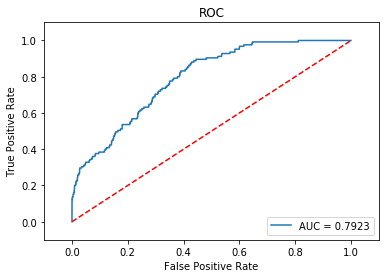

In [72]:
plt.title('ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
gini_ind = (2*roc_auc)-1
print('Индекс Джини равен: ', gini_ind)

Индекс Джини равен:  0.5845823312489979


### Чтобы подсчитать Precision и Recall, необходимо преобразовать вероятности в бинарный ответ, для этого определим порог, то есть будем считать, что если вероятность просрочки для человека больше 0.5, то просрочка состоится.

In [74]:
test_results[test_results > 0.5]

array([0.99984673, 0.99989884, 0.99992558, 0.85335073, 0.77148994,
       0.99992979, 0.9999574 , 0.99994906, 0.80624092, 0.99994911,
       0.99995528, 0.99010498, 0.99987241, 0.91180702, 0.95275951,
       0.98971504, 0.99995437])

In [75]:
print('F1-мера равняется: ', f1_score(y_test, np.around(test_results)))

F1-мера равняется:  0.21126760563380279


# Вопрос №5. Провести анализ Reject Inference. Какая доля отказанных заявок?

Исполним технику hard cutoff. Строим модель логистической регресии на всех одобренных заявках и применяем её к отказанным заявкам.

In [76]:
int_vars_df_r

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport
0,26106.000,1.667,24.353,3.284,4.268
1,30276.000,0.660,23.534,3.581,1.411
2,23147.000,4.342,24.580,0.646,4.544
3,33116.000,0.759,23.284,0.901,3.183
4,45972.000,nan,24.529,1.405,3.582
...,...,...,...,...,...
10688,24311.000,nan,23.456,1.188,3.402
10689,21400.000,1.272,24.041,0.994,2.740
10690,22532.000,0.601,24.443,0.569,4.377
10691,21750.000,nan,23.219,0.742,3.002


In [77]:
cat_vars_df_r

,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day
0,2NDFL,elementary,NaN,0,0.000,0.000,1.000,1.000
1,2NDFL,elementary,NaN,0,0.000,1.000,0.000,0.000
2,2NDFL,advanced,NaN,0,0.000,0.000,0.000,1.000
3,2NDFL,advanced,NaN,0,0.000,0.000,0.000,0.000
4,2NDFL,elementary,NaN,0,0.000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
10688,2NDFL,advanced,NaN,0,0.000,NaN,NaN,NaN
10689,OTHER,elementary,NaN,0,0.000,0.000,0.000,0.000
10690,OTHER,elementary,Corporate,1,0.000,1.000,1.000,1.000
10691,OTHER,elementary,NaN,0,0.000,NaN,NaN,NaN


### Переведём все интервальные переменные из новой выборки в категориальные, согласно тому разбиению бинов, которое было на выборке accept

In [78]:
bins=[-0.001, 24948.4, 35000.0, 50000.0, 80000.0, 8000000.0]
int_vars_df_r['income'] = pd.cut(int_vars_df_r['income'], bins=[-0.001, 24948.4, 35000.0, 50000.0, 80000.0, 8000000.0], labels=['income<=24948', '24948<income<=35000', '35000<income<=50000', '50000<income<=80000', 'income>80000'])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
bins = [-0.001, 0.476, 0.763, 1.145, 6.046, 89.053]
int_vars_df_r['CNT_MNTH_FROM_LAST_PMNT'] = pd.cut(int_vars_df_r['CNT_MNTH_FROM_LAST_PMNT'], bins, labels=['CNT_MNTH_FROM_LAST_PMNT<=0.476', '0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763', '0.763<CNT_MNTH_FROM_LAST_PMNT<=1.145', '1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046', 'CNT_MNTH_FROM_LAST_PMNT>6.046'])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [80]:
bins = [-0.001, 28.741, 32.505, 37.533, 44.435, 62.321]
int_vars_df_r['age'] = pd.cut(int_vars_df_r['age'], bins, labels=['age<=28.741', '28.741<age<=32.505', '32.505<age<=37.533', '37.533<age<=44.435', 'age>44.435'])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [81]:
bins = [-0.001, 0.957, 2.327, 4.433, 7.499, 100.355]
int_vars_df_r['experience'] = pd.cut(int_vars_df_r['experience'], bins, labels=['experience<=0.957', '0.957<experience<=2.327', '2.327<experience<=4.433', '4.433<experience<=7.499', 'experience>7.499'])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
bins = [-0.001, 4.139, 6.647, 8.827, 10.239, 15.805]
int_vars_df_r['count_mnth_act_passport'] = pd.cut(int_vars_df_r['count_mnth_act_passport'], bins, labels=['count_mnth_act_passport<=4.139', '4.139<count_mnth_act_passport<=6.647', '6.647<count_mnth_act_passport<=8.827', '8.827<count_mnth_act_passport<=10.239', 'count_mnth_act_passport>10.239'])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
int_vars_df_r

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport
0,24948<income<=35000,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,age<=28.741,2.327<experience<=4.433,4.139<count_mnth_act_passport<=6.647
1,24948<income<=35000,0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763,age<=28.741,2.327<experience<=4.433,count_mnth_act_passport<=4.139
2,income<=24948,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,age<=28.741,experience<=0.957,4.139<count_mnth_act_passport<=6.647
3,24948<income<=35000,0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763,age<=28.741,experience<=0.957,count_mnth_act_passport<=4.139
4,35000<income<=50000,NaN,age<=28.741,0.957<experience<=2.327,count_mnth_act_passport<=4.139
...,...,...,...,...,...
10688,income<=24948,NaN,age<=28.741,0.957<experience<=2.327,count_mnth_act_passport<=4.139
10689,income<=24948,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,age<=28.741,0.957<experience<=2.327,count_mnth_act_passport<=4.139
10690,income<=24948,0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763,age<=28.741,experience<=0.957,4.139<count_mnth_act_passport<=6.647
10691,income<=24948,NaN,age<=28.741,experience<=0.957,count_mnth_act_passport<=4.139


In [84]:
int_vars_df_r = int_vars_df_r.astype('object')
int_vars_df_r = int_vars_df_r.fillna('NaN')
int_vars_df_r

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport
0,24948<income<=35000,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,age<=28.741,2.327<experience<=4.433,4.139<count_mnth_act_passport<=6.647
1,24948<income<=35000,0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763,age<=28.741,2.327<experience<=4.433,count_mnth_act_passport<=4.139
2,income<=24948,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,age<=28.741,experience<=0.957,4.139<count_mnth_act_passport<=6.647
3,24948<income<=35000,0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763,age<=28.741,experience<=0.957,count_mnth_act_passport<=4.139
4,35000<income<=50000,NaN,age<=28.741,0.957<experience<=2.327,count_mnth_act_passport<=4.139
...,...,...,...,...,...
10688,income<=24948,NaN,age<=28.741,0.957<experience<=2.327,count_mnth_act_passport<=4.139
10689,income<=24948,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,age<=28.741,0.957<experience<=2.327,count_mnth_act_passport<=4.139
10690,income<=24948,0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763,age<=28.741,experience<=0.957,4.139<count_mnth_act_passport<=6.647
10691,income<=24948,NaN,age<=28.741,experience<=0.957,count_mnth_act_passport<=4.139


### Объединим интервальные и категориальные переменные для выборки reject

In [85]:
r_vars_combined = int_vars_df_r.join(cat_vars_df_r)

In [86]:
r_vars_combined['target'] = 0 #Эта строчка нужна для корректной работы алгоритма, она не повлияет на конечный результат
r_vars_combined = r_vars_combined.fillna('NaN')
r_vars_combined

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day,target
0,24948<income<=35000,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,age<=28.741,2.327<experience<=4.433,4.139<count_mnth_act_passport<=6.647,2NDFL,elementary,NaN,0,0.000,0.000,1.000,1.000,0
1,24948<income<=35000,0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763,age<=28.741,2.327<experience<=4.433,count_mnth_act_passport<=4.139,2NDFL,elementary,NaN,0,0.000,1.000,0.000,0.000,0
2,income<=24948,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,age<=28.741,experience<=0.957,4.139<count_mnth_act_passport<=6.647,2NDFL,advanced,NaN,0,0.000,0.000,0.000,1.000,0
3,24948<income<=35000,0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763,age<=28.741,experience<=0.957,count_mnth_act_passport<=4.139,2NDFL,advanced,NaN,0,0.000,0.000,0.000,0.000,0
4,35000<income<=50000,NaN,age<=28.741,0.957<experience<=2.327,count_mnth_act_passport<=4.139,2NDFL,elementary,NaN,0,0.000,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,income<=24948,NaN,age<=28.741,0.957<experience<=2.327,count_mnth_act_passport<=4.139,2NDFL,advanced,NaN,0,0.000,NaN,NaN,NaN,0
10689,income<=24948,1.145<CNT_MNTH_FROM_LAST_PMNT<=6.046,age<=28.741,0.957<experience<=2.327,count_mnth_act_passport<=4.139,OTHER,elementary,NaN,0,0.000,0.000,0.000,0.000,0
10690,income<=24948,0.476<CNT_MNTH_FROM_LAST_PMNT<=0.763,age<=28.741,experience<=0.957,4.139<count_mnth_act_passport<=6.647,OTHER,elementary,Corporate,1,0.000,1.000,1.000,1.000,0
10691,income<=24948,NaN,age<=28.741,experience<=0.957,count_mnth_act_passport<=4.139,OTHER,elementary,NaN,0,0.000,NaN,NaN,NaN,0


### Преобразуем значения выборки reject с помощью WoE, определённых ранее

In [87]:
WoE_vars = r_vars_combined.copy()
IV_total = []
for i in range(len(df_vars_combined_train.columns)):
    lst = []
    IV = []
    for j in range(len(df_vars_combined_train.iloc[:, i].unique())):
        val = df_vars_combined_train.iloc[:, i].unique()[j]
        target_sum = df_vars_combined_train[df_vars_combined_train.iloc[:, i] == val]['target'].sum() #Количество единиц
        zero_sum = (df_vars_combined_train[df_vars_combined_train.iloc[:, i] == val]['target'].count() - target_sum) #Количество нулей
        rel_freq_1 = target_sum/df_vars_combined_train['target'].sum()
        rel_freq_0 = zero_sum/(df_vars_combined_train['target'].count() - df_vars_combined_train['target'].sum())
        if rel_freq_1 == 0:
            rel_freq_1 = 0.000001
        if rel_freq_0 == 0:
            rel_freq_0 = 0.000001
        var_WoE = np.log(rel_freq_0 / rel_freq_1)
        IV_value = (rel_freq_0 - rel_freq_1)*var_WoE
        IV.append(IV_value)
        lst.append(var_WoE)
        WoE_vars[r_vars_combined.columns[i]][WoE_vars[r_vars_combined.columns[i]] == val] = lst[j]
    IV_total.append(sum(IV))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Новый Information Value для объединённой выборки

In [88]:
IV_df = pd.DataFrame()
IV_df['variable'] = r_vars_combined.columns
IV_df['Information Value'] = IV_total
IV_df.drop(13, axis=0)

,variable,Information Value
0,income,0.112
1,CNT_MNTH_FROM_LAST_PMNT,0.117
2,age,0.003
3,experience,0.601
4,count_mnth_act_passport,0.080
5,INCOME_TYPE,0.003
6,EDUCATION_,0.040
7,CUSTOMER_CATEGORY_,0.435
8,IS_EMPL,0.699
9,DEPENDANT_NUMBER,0.396


In [89]:
WoE_vars = WoE_vars.drop('target', axis=1)
WoE_vars

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day
0,-0.025,0.388,-0.048,-0.175,-0.200,0.082,0.134,-0.392,-0.443,0.058,0.425,-0.129,0.026
1,-0.025,-0.118,-0.048,-0.175,-0.377,0.082,0.134,-0.392,-0.443,0.058,0.121,0.390,0.409
2,0.357,0.388,-0.048,-0.179,-0.200,0.082,-0.222,-0.392,-0.443,0.058,0.425,0.390,0.026
3,-0.025,-0.118,-0.048,-0.179,-0.377,0.082,-0.222,-0.392,-0.443,0.058,0.425,0.390,0.409
4,-0.136,-0.299,-0.048,-0.157,-0.377,0.082,0.134,-0.392,-0.443,0.058,-0.394,-0.315,-0.315
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,0.357,-0.299,-0.048,-0.157,-0.377,0.082,-0.222,-0.392,-0.443,0.058,-0.394,-0.315,-0.315
10689,0.357,0.388,-0.048,-0.157,-0.377,-0.038,0.134,-0.392,-0.443,0.058,0.425,0.390,0.409
10690,0.357,-0.118,-0.048,-0.179,-0.200,-0.038,0.134,1.146,1.672,0.058,0.121,-0.129,0.026
10691,0.357,-0.299,-0.048,-0.179,-0.377,-0.038,0.134,-0.392,-0.443,0.058,-0.394,-0.315,-0.315


### Построим предсказания для отклонённых заявок с помощью логистической регрессии, обученной на всех одобренных заявках

In [90]:
regressor = LogisticRegression(solver='lbfgs', max_iter=100, C=1, random_state=13)
y = df_total['target']
X = df_total.drop('target', axis=1)
regressor.fit(X, y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
WoE_vars = WoE_vars.astype('float64')

### При предсказаниях sklearn по неизвестной причине выдавал ошибку, поэтому пришлось прибегнуть к функции ниже

In [92]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [93]:
WoE_vars = clean_dataset(WoE_vars)

In [94]:
WoE_vars

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day
0,-0.025,0.388,-0.048,-0.175,-0.200,0.082,0.134,-0.392,-0.443,0.058,0.425,-0.129,0.026
1,-0.025,-0.118,-0.048,-0.175,-0.377,0.082,0.134,-0.392,-0.443,0.058,0.121,0.390,0.409
2,0.357,0.388,-0.048,-0.179,-0.200,0.082,-0.222,-0.392,-0.443,0.058,0.425,0.390,0.026
3,-0.025,-0.118,-0.048,-0.179,-0.377,0.082,-0.222,-0.392,-0.443,0.058,0.425,0.390,0.409
4,-0.136,-0.299,-0.048,-0.157,-0.377,0.082,0.134,-0.392,-0.443,0.058,-0.394,-0.315,-0.315
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,0.357,-0.299,-0.048,-0.157,-0.377,0.082,-0.222,-0.392,-0.443,0.058,-0.394,-0.315,-0.315
10689,0.357,0.388,-0.048,-0.157,-0.377,-0.038,0.134,-0.392,-0.443,0.058,0.425,0.390,0.409
10690,0.357,-0.118,-0.048,-0.179,-0.200,-0.038,0.134,1.146,1.672,0.058,0.121,-0.129,0.026
10691,0.357,-0.299,-0.048,-0.179,-0.377,-0.038,0.134,-0.392,-0.443,0.058,-0.394,-0.315,-0.315


### Получаем вероятности просрочки для каждого наблюдения для отказанных заявок

### Будем считать, что человек бы просрочил платёж, если вероятность в модели составила больше 0.05

In [95]:
test_results = regressor.predict_proba(WoE_vars)[:, 1]

In [96]:
test_results[test_results > 0.05] = 1
test_results[test_results <= 0.05] = 0

## Вопрос №6. Построить логистическую регрессию на всех заявках с преобразованными переменными WoE. Какое значение GINI, F1? Изменилась ли модель?

In [97]:
rej_inf_df = WoE_vars
rej_inf_df['target'] = test_results

### Объединяем заявки accept и заявки reject

In [98]:
df_full = pd.concat([df_total, rej_inf_df])
df_full

,income,CNT_MNTH_FROM_LAST_PMNT,age,experience,count_mnth_act_passport,INCOME_TYPE,EDUCATION_,CUSTOMER_CATEGORY_,IS_EMPL,DEPENDANT_NUMBER,COUNT_ACTIVE_CREDIT_NO_CC,inquiry_14_day,inquiry_21_day,target
0,0.405,0.802,-0.009,-0.175,0.161,-0.038,0.134,-0.392,-0.443,0.058,0.425,-0.315,-0.315,0.000
1,0.357,-0.083,0.038,0.945,0.161,0.082,-0.222,-0.392,-0.443,0.058,0.121,0.390,0.409,0.000
2,0.357,-0.299,0.038,-0.157,0.340,-0.038,-0.222,1.146,1.672,0.058,-0.394,-0.315,-0.315,0.000
3,0.405,0.802,0.038,-0.179,0.340,-0.038,0.134,1.267,1.672,0.058,0.425,0.390,0.409,0.000
4,-0.136,-0.299,0.082,0.283,-0.377,-0.038,0.134,-0.392,-0.443,0.058,-0.394,-0.315,-0.315,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10688,0.357,-0.299,-0.048,-0.157,-0.377,0.082,-0.222,-0.392,-0.443,0.058,-0.394,-0.315,-0.315,1.000
10689,0.357,0.388,-0.048,-0.157,-0.377,-0.038,0.134,-0.392,-0.443,0.058,0.425,0.390,0.409,0.000
10690,0.357,-0.118,-0.048,-0.179,-0.200,-0.038,0.134,1.146,1.672,0.058,0.121,-0.129,0.026,0.000
10691,0.357,-0.299,-0.048,-0.179,-0.377,-0.038,0.134,-0.392,-0.443,0.058,-0.394,-0.315,-0.315,1.000


In [99]:
y = df_full['target']
X = df_full.drop('target', axis=1)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [101]:
regressor = LogisticRegression(solver='lbfgs', max_iter=100, C=1, random_state=13)
regressor.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=13, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Получаем вероятности просрочки для каждого наблюдения на тестовой выборке, чтобы определить качество модели

In [102]:
test_results = regressor.predict_proba(X_test)[:, 1]
test_results

array([0.10380424, 0.02260395, 0.04385754, ..., 0.00056056, 0.00010626,
       0.0422386 ])

### Подсчитываем метрику ROC-AUC для подсчёта индекса Джини и строим ROC-кривую

In [103]:
fpr, tpr, thresholds = roc_curve(y_test, test_results)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9267718703816318


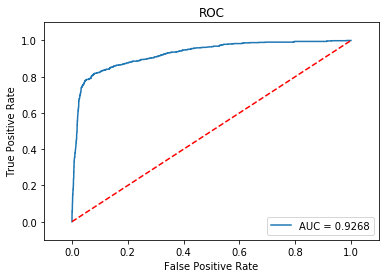

In [104]:
plt.title('ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [105]:
gini_ind = (2*roc_auc)-1
print('Индекс Джини равен: ', gini_ind)

Индекс Джини равен:  0.8535437407632636


### Чтобы подсчитать Precision и Recall, необходимо преобразовать вероятности в бинарный ответ, для этого определим порог, то есть будем считать, что если вероятность просрочки для человека больше 0.5, то просрочка состоится.


In [106]:
print('F1-мера равняется: ', f1_score(y_test, np.around(test_results)))

F1-мера равняется:  0.33665338645418325


## Вопрос №7. Какую модель вы рекомендуете для внедрения в продуктивную среду? Дать развернутое пояснение

Моя рекомендация - модель с использованием reject inference по следующим причинам:
1. Прежде всего, на это указывают итоговые метрики.
Индекс Джини только на выборке accept: 0.59
Индекс Джини на объединённой выборке: 0.86
F1-мера только на выборке accept: 0.21
F1-мера на объединённой выборке: 0.34

2. Выборка, основанная только на одобренных заявках, является смещённой, а, следовательно, и предсказания на ней будут также смещены!

3. Те люди, которым было отказано, будут, возможно, приходить повторно, и если модель не будет учитывать отказные заявки, то этот человек, возможно, ещё очень долго не сможет получить кредит.